## Metadata Integration

In [1]:
import os.path as osp
import pandas as pd
import numpy as np
%run env.py
%run src/lib.py
%run src/meta.py
%matplotlib inline
MIN_SYM_LEN = 3

In [2]:
import hashlib
ID_TYP_CK = 'CK'
ID_TYP_TF = 'TF'
ID_TYP_CT = 'CT'

def get_ids(df, typ):
    ids = [':'.join([r['src'], str(r['spid']), r['sym'], r['lbl']]) for _, r in df.iterrows()]
    return [typ + hashlib.md5(v.encode('utf-8')).hexdigest()[:16].upper() for v in ids]

def merge(dfs, typ):
    cols = ['id', 'src', 'sym', 'lbl', 'spid', 'extid']
    dfs = [df.copy() for df in dfs]
    for df in dfs:
        if 'id' in df:
            raise ValueError('ID should not already be assigned')
        df['id'] = get_ids(df, typ)
    df = pd.concat([df[cols] for df in dfs])
    return df

## Cytokines

#### Load from book table (Cameron and Kelvin)

From: https://www.ncbi.nlm.nih.gov/books/NBK6294/table/A13506/?report=objectonly

In [3]:
SRC = 'cameron'
dfr = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'cytokines.cameron.csv'), sep='\t')
dfr.head()

,name,synonym,amino,chromosome_acids,mwt,receptor_form,receptor_location
0,IL-1α,hematopoietin-1,271,2q14,30606,"CD121a, CDw121b","2q12, 2q12-q22"
1,IL-1β,catabolin,269,2q14,20747,"CD121a, CDw121b","2q12,2q12-q22"
2,IL-1RA,IL-1 receptor antagonist,177,2q14.2,20055,CD121a,2q12
3,IL-18,interferon-γ inducing factor,193,11q22.2-q22.3,22326,"IL-18Rα, β",2q12
4,IL-2,T cell growth factor,153,4q26-q27,17628,"CD25, 122,132","10p15-p14, 22q13.1, Xq13.1"


In [4]:
dft = (
    pd.concat([
        dfr[['name', 'name']].set_axis(['sym', 'lbl'], axis=1, inplace=False),
        dfr.set_index('name')['synonym'].str.split(',', expand=True).stack().str.strip()
            .reset_index().set_axis(['lbl', 'i', 'sym'], axis=1, inplace=False)
            .filter(items=['sym', 'lbl'])
    ])
    .assign(spid=SPECIES_HUMAN_ID, src=SRC)
)
dft.head()

,sym,lbl,spid,src
0,IL-1α,IL-1α,1,cameron
1,IL-1β,IL-1β,1,cameron
2,IL-1RA,IL-1RA,1,cameron
3,IL-18,IL-18,1,cameron
4,IL-2,IL-2,1,cameron


In [5]:
def transform(df, mask, fn):
    df = df.loc[mask.values].copy()
    df['sym'] = df['sym'].apply(fn)
    return df
df = dft.append(transform(dft, dft['sym'].str.match(r'IL-[^ ]+$|TNF-|IFN-|TGF-'), lambda v: v.replace('-', '')))
df['sym'] = df['sym'].str.strip()
df['lbl'] = df['lbl'].str.strip()
df['extid'] = None
df = df[df['sym'].str.len() > 0]
df.head()

,sym,lbl,spid,src,extid
0,IL-1α,IL-1α,1,cameron,None
1,IL-1β,IL-1β,1,cameron,None
2,IL-1RA,IL-1RA,1,cameron,None
3,IL-18,IL-18,1,cameron,None
4,IL-2,IL-2,1,cameron,None


In [6]:
df['sym'].unique()

array(['IL-1α', 'IL-1β', 'IL-1RA', 'IL-18', 'IL-2', 'IL-4', 'IL-7',
       'IL-9', 'IL-13', 'IL-15', 'IL-3', 'IL-5', 'GM-CSF', 'IL-6',
       'IL-11', 'G-CSF', 'IL-12', 'LIF', 'OSM', 'IL-10', 'IL-20', 'IL-14',
       'IL-16', 'IL-17', 'IFN-α', 'IFN-β', 'IFN-γ', 'CD154', 'LT-β',
       'TNF-α', 'TNF-β', '4-1BBL', 'APRIL', 'CD70', 'CD153', 'CD178',
       'GITRL', 'LIGHT', 'OX40L', 'TALL-1', 'TRAIL', 'TWEAK', 'TRANCE',
       'TGF-β1', 'TGF-β2', 'TGF-β3', 'hematopoietin-1', 'catabolin',
       'IL-1 receptor antagonist', 'interferon-γ inducing factor',
       'T cell growth factor', 'BSF-1', 'T cell growth factor P40',
       'P600', 'multipotential CSF', 'MCGF', 'BCDF-1', 'CSF-2', 'IFN-β2',
       'BSF-2', 'AGIF', 'CSF-3', 'NK cell stimulatory factor',
       'leukemia inhibitory factor', 'oncostatin M', 'CSIF', 'HMW-BCGF',
       'LCF', 'CTLA-8', 'CD40L', 'TRAP', 'cachectin', 'LT-α', 'TALL-2',
       'CD27L', 'CD30L', 'FasL', 'Apo2L', 'Apo3L', 'OPGL', 'TGF-β',
       'IL1α', 'IL1β', 'I

In [7]:
df_cameron = df.copy()

#### Load from mygene

Original result info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 8 columns):
_id             571 non-null object
_score          571 non-null float64
alias           532 non-null object
ensembl         30 non-null object
ensembl.gene    523 non-null object
name            571 non-null object
symbol          571 non-null object
taxid           571 non-null int64
dtypes: float64(1), int64(1), object(6)
memory usage: 35.8+ KB
None
Score histogram:


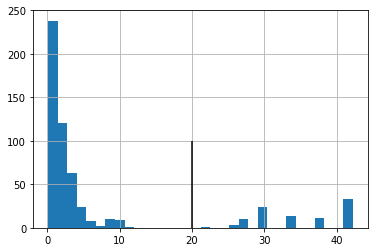

In [8]:
SRC = 'mygene'
df = mygene_query('interleukin')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 7 columns):
extid           95 non-null object
alias           90 non-null object
ensembl         0 non-null object
ensembl.gene    94 non-null object
name            95 non-null object
symbol          95 non-null object
taxid           95 non-null int64
dtypes: int64(1), object(6)
memory usage: 5.9+ KB


In [10]:
df = df[df['name'].str.match('interleukin \w+$')]
df = mygene_prep(df)
df = df.assign(spid=SPECIES_HUMAN_ID, src=SRC)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
sym      200 non-null object
lbl      200 non-null object
extid    200 non-null object
spid     200 non-null int64
src      200 non-null object
dtypes: int64(1), object(4)
memory usage: 7.9+ KB
None


,sym,lbl,extid,spid,src
0,interleukin 3,IL3,3562,1,mygene
1,IL3,IL3,3562,1,mygene
2,IL-3,IL3,3562,1,mygene
3,MCGF,IL3,3562,1,mygene
4,MULTI-CSF,IL3,3562,1,mygene


In [11]:
df['lbl'].unique()

array(['IL3', 'IL25', 'IL26', 'IL17A', 'IL17D', 'IL18', 'IL7', 'IL16',
       'IL20', 'IL27', 'IL33', 'IL34', 'IL17C', 'IL17B', 'IL17F', 'IL9',
       'IL15', 'IL19', 'IL5', 'IL11', 'IL6', 'IL10', 'IL12B', 'IL13',
       'IL2', 'IL24', 'IL31', 'IL22', 'IL32', 'IL12A', 'IL37', 'IL21',
       'IL4'], dtype=object)

In [12]:
# Check for (and remove) any excessively vague symbols
df['sym'].unique()

array(['interleukin 3', 'IL3', 'IL-3', 'MCGF', 'MULTI-CSF',
       'interleukin 25', 'IL25', 'IL17E', 'interleukin 26', 'IL26',
       'AK155', 'IL-26', 'interleukin 17A', 'IL17A', 'CTLA-8', 'CTLA8',
       'IL-17', 'IL-17A', 'IL17', 'interleukin 17D', 'IL17D', 'IL-17D',
       'interleukin 18', 'IL18', 'IGIF', 'IL-18', 'IL-1g', 'IL1F4',
       'interleukin 7', 'IL7', 'IL-7', 'interleukin 16', 'IL16', 'LCF',
       'NIL16', 'PRIL16', 'prIL-16', 'interleukin 20', 'IL20', 'IL-20',
       'IL10D', 'ZCYTO10', 'interleukin 27', 'IL27', 'IL-27', 'IL-27A',
       'IL27A', 'IL27p28', 'IL30', 'p28', 'interleukin 33', 'IL33',
       'C9orf26', 'DVS27', 'IL1F11', 'NF-HEV', 'NFEHEV', 'interleukin 34',
       'IL34', 'C16orf77', 'IL-34', 'interleukin 17C', 'IL17C', 'CX2',
       'IL-17C', 'interleukin 17B', 'IL17B', 'IL-17B', 'NIRF', 'ZCYTO7',
       'interleukin 17F', 'IL17F', 'CANDF6', 'IL-17F', 'ML-1', 'ML1',
       'interleukin 9', 'IL9', 'HP40', 'IL-9', 'P40', 'interleukin 15',
       'IL15', 

In [13]:
df[df['sym'].str.match('lymphokine')]

,sym,lbl,extid,spid,src
134,lymphokine,IL2,3558,1,mygene


In [14]:
dfs = df[~df['sym'].str.match('lymphokine')]
len(dfs), len(df)

(199, 200)

In [15]:
df_mygene = dfs.copy()

In [16]:
df_mygene[df_mygene['lbl'] == 'IL2']

,sym,lbl,extid,spid,src
130,interleukin 2,IL2,3558,1,mygene
131,IL2,IL2,3558,1,mygene
132,IL-2,IL2,3558,1,mygene
133,TCGF,IL2,3558,1,mygene


#### Load Manual Entries

In [17]:
SRC = 'manual'
df = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'cytokines.manual.csv'), sep=',')
df = df.assign(src=SRC, extid=None)
df.head()

,sym,lbl,spid,src,extid
0,IL-23,IL23,1,manual,None
1,IL23,IL23,1,manual,None
2,IL12α,IL12A,1,manual,None
3,IL-12α,IL12A,1,manual,None
4,IL-12 p35,IL12A,1,manual,None


In [18]:
df_manual = df.copy()

#### Merge and Export

In [19]:
df = merge([df_cameron, df_mygene, df_manual], ID_TYP_CK)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321 entries, 0 to 10
Data columns (total 6 columns):
id       321 non-null object
src      321 non-null object
sym      321 non-null object
lbl      321 non-null object
spid     321 non-null int64
extid    199 non-null object
dtypes: int64(1), object(5)
memory usage: 17.6+ KB
None


,id,src,sym,lbl,spid,extid
0,CK3618F8D5635EA31B,cameron,IL-1α,IL-1α,1,None
1,CKA07F01C879D8D6C2,cameron,IL-1β,IL-1β,1,None
2,CKA95B181F6273B58D,cameron,IL-1RA,IL-1RA,1,None
3,CKBF6003C60D23BA0D,cameron,IL-18,IL-18,1,None
4,CKD21834C7D75FD77F,cameron,IL-2,IL-2,1,None


In [20]:
rm_sym = df[df['sym'].str.len() < MIN_SYM_LEN]['sym'].unique()
print('Removing {} records with excessively short symbols: {}'.format(len(rm_sym), rm_sym))
df = df[~df['sym'].isin(rm_sym)]
df.info()

Removing 0 records with excessively short symbols: []
<class 'pandas.core.frame.DataFrame'>
Int64Index: 321 entries, 0 to 10
Data columns (total 6 columns):
id       321 non-null object
src      321 non-null object
sym      321 non-null object
lbl      321 non-null object
spid     321 non-null int64
extid    199 non-null object
dtypes: int64(1), object(5)
memory usage: 17.6+ KB


In [21]:
df[df['sym'].str.match('TGF.$')]

,id,src,sym,lbl,spid,extid
46,CK8ADDB4814EC2BC7A,cameron,TGFβ,TGF-β1,1,None


In [22]:
path = osp.join(META_DATA_DIR, 'cytokines.csv')
df.to_csv(path, index=False)
path

'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/meta/cytokines.csv'

## Transcription Factors

#### Load from Lambert, et al. 2016

In [24]:
SRC = 'lambert'
# Load export of tab "Table S1. Related to Figure 1B-Table 1.csv" from Document S1 in
# https://doi.org/10.1016%2Fj.cell.2018.01.029 (containing *human* transcription factors)
df = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'transcription_factors.lambert.csv'), header=[0,1])
df = df[df['Is TF?'].iloc[:,0] == 'Yes']
df = df[[('Gene Information', 'ID'), ('Unnamed: 1_level_0', 'Name')]]
df.columns = ['extid', 'lbl']
df = df.assign(sym=df['lbl'].values, spid=SPECIES_HUMAN_ID, src=SRC)
df['spid'] = SPECIES_HUMAN_ID
# Ensure number of records from spreadsheet export matches https://en.wikipedia.org/wiki/List_of_human_transcription_factors
assert len(df) == 1639, \
    'Data frame does not have expected row count 1639 '\
    '(count should match https://en.wikipedia.org/wiki/List_of_human_transcription_factors)'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1639 entries, 0 to 2763
Data columns (total 5 columns):
extid    1639 non-null object
lbl      1639 non-null object
sym      1639 non-null object
spid     1639 non-null int64
src      1639 non-null object
dtypes: int64(1), object(4)
memory usage: 76.8+ KB


In [25]:
df.head()

,extid,lbl,sym,spid,src
0,ENSG00000137203,TFAP2A,TFAP2A,1,lambert
1,ENSG00000008196,TFAP2B,TFAP2B,1,lambert
2,ENSG00000087510,TFAP2C,TFAP2C,1,lambert
3,ENSG00000008197,TFAP2D,TFAP2D,1,lambert
4,ENSG00000116819,TFAP2E,TFAP2E,1,lambert


In [26]:
# Use MyGene to get aliases for genes above (by ensembl id, not symbol/name)
dfa = mg.getgenes(
    ids=df['extid'].unique(),
    scopes=["symbol", "retired", "name", "alias"],
    fields='symbol,name,taxid,ensembl.gene,alias', 
    as_dataframe=True
)
dfa['extid'] = dfa.index
dfa.info()

querying 1-1000...done.
querying 1001-1639...done.
<class 'pandas.core.frame.DataFrame'>
Index: 1639 entries, ENSG00000137203 to ENSG00000168152
Data columns (total 10 columns):
_id             1636 non-null object
_score          1636 non-null float64
alias           1310 non-null object
ensembl         77 non-null object
ensembl.gene    1559 non-null object
name            1633 non-null object
notfound        3 non-null object
symbol          1636 non-null object
taxid           1636 non-null float64
extid           1639 non-null object
dtypes: float64(2), object(8)
memory usage: 140.9+ KB


In [27]:
# Use MyGene to get aliases for genes above (by ensembl id, not symbol/name)
dfa = mg.getgenes(
    ids=df['extid'].unique(),
    scopes=["symbol", "retired", "name", "alias"],
    fields='symbol,name,taxid,ensembl.gene,alias', 
    as_dataframe=True
)
# The query term is set as the index in results so use that to get the ensembl id
# rather than the `ensenbl.gene` field since this is inexplicably empty sometimes
# even when the query term as an ensembl id and all other fields are valid (e.g.
# ENSG00000232040 --> gives symbol ZBED9 and valid aliases but empty gene id field)
dfa['extid'] = dfa.index
dfa = mygene_prep(dfa)
dfa = dfa.assign(spid=SPECIES_HUMAN_ID, src=SRC)
dfa = dfa[dfa['lbl'].notnull() & dfa['sym'].notnull()]
assert dfa['extid'].notnull().all()
dfa.info()

querying 1-1000...done.
querying 1001-1639...done.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7366 entries, 0 to 7374
Data columns (total 5 columns):
sym      7366 non-null object
lbl      7366 non-null object
extid    7366 non-null object
spid     7366 non-null int64
src      7366 non-null object
dtypes: int64(1), object(4)
memory usage: 345.3+ KB


In [28]:
dfm = pd.concat([df, dfa[df.columns]])
# As the mygene results may contain aliases matching the names
# in the lambert spreadsheet and the `src` is the same, duplicates
# should be removed 
dfm = dfm.drop_duplicates()
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377 entries, 0 to 7374
Data columns (total 5 columns):
extid    7377 non-null object
lbl      7377 non-null object
sym      7377 non-null object
spid     7377 non-null int64
src      7377 non-null object
dtypes: int64(1), object(4)
memory usage: 345.8+ KB


In [29]:
df_lambert = dfm.copy()

In [29]:
#df_lambert[df_lambert['sym'].str.lower().str.contains('t-bet')]

#### Load Manual Entries

In [30]:
SRC = 'manual'
df = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'transcription_factors.manual.csv'), sep=',')
df = df.assign(src=SRC, extid=None)
df.head()

,sym,lbl,spid,src,extid


In [31]:
df_manual = df.copy()

#### Merge and Export

In [32]:
df = merge([df_lambert, df_manual], ID_TYP_TF)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377 entries, 0 to 7374
Data columns (total 6 columns):
id       7377 non-null object
src      7377 non-null object
sym      7377 non-null object
lbl      7377 non-null object
spid     7377 non-null object
extid    7377 non-null object
dtypes: object(6)
memory usage: 403.4+ KB
None


,id,src,sym,lbl,spid,extid
0,TF86C36DA44F437EF4,lambert,TFAP2A,TFAP2A,1,ENSG00000137203
1,TF461FDA506812E746,lambert,TFAP2B,TFAP2B,1,ENSG00000008196
2,TFC45A94C937B61266,lambert,TFAP2C,TFAP2C,1,ENSG00000087510
3,TF688FFC3D7A50AA7B,lambert,TFAP2D,TFAP2D,1,ENSG00000008197
4,TFEF8EA5EE07436793,lambert,TFAP2E,TFAP2E,1,ENSG00000116819


In [33]:
rm_sym = df[df['sym'].str.len() < MIN_SYM_LEN]['sym'].unique()
print('Removing {} records with excessively short symbols: {}'.format(len(rm_sym), rm_sym))
df = df[~df['sym'].isin(rm_sym)]
df.info()

Removing 25 records with excessively short symbols: ['AR' 'T' 'MI' 'ZF' 'Y8' 'RN' 'NP' 'OF' 'LD' 'H6' 'PL' 'K8' 'RS' 'RX' 'SS'
 'AN' 'L8' 'KD' 'ER' 'GR' 'MR' 'PR' 'D9' 'LF' 'AA']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7350 entries, 0 to 7374
Data columns (total 6 columns):
id       7350 non-null object
src      7350 non-null object
sym      7350 non-null object
lbl      7350 non-null object
spid     7350 non-null object
extid    7350 non-null object
dtypes: object(6)
memory usage: 402.0+ KB


In [34]:
df[df['sym'].str.lower().str.contains('gfi')]

,id,src,sym,lbl,spid,extid
265,TF1FEE043B45D9654E,lambert,GFI1,GFI1,1,ENSG00000162676
266,TF06386BF18D80F1C5,lambert,GFI1B,GFI1B,1,ENSG00000165702
1200,TFD6425765B0AF5303,lambert,NGFI-A,EGR1,1,ENSG00000120738
1218,TF6AD173F0E42A506C,lambert,NGFI-C,EGR4,1,ENSG00000135625
1219,TFA77682C38E2A0D4F,lambert,NGFIC,EGR4,1,ENSG00000135625
1242,TFE156A51136C217BC,lambert,GFI-1,GFI1,1,ENSG00000162676
1243,TFD513B64FD7B6A5DF,lambert,GFI1A,GFI1,1,ENSG00000162676
6376,TF03C9CAC32D70E497,lambert,NGFIB,NR4A1,1,ENSG00000123358


In [36]:
path = osp.join(META_DATA_DIR, 'transcription_factors.csv')
df.to_csv(path, index=False)
path

'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/meta/transcription_factors.csv'

## Cell Types

In [35]:
SRC = 'manual'
cell_types = [
    ('TN', ['T-naïve', 'naïve-T']),
    ('TEMRA', ['T-emra', 'emra-T']),
    ('TCM', ['T-cm', 'cm-T']),
    ('TEFF', ['T-eff', 'T-effector', 'eff-T', 'effector-T']),
    ('TEM', ['T-em', 'em-T']),
    ('Th', ['T-Helper', 'Helper-T']),
    ('ThP', ['Th-Precursor', 'Precursor-Th']),
    ('Trm', ['T-rm', 'T-resident-memory', 'resident-memory-T']),
    ('Tscm', ['T-SCM']),
    ('NKT', ['natural-killer-T', 'T-natural-killer', 'INKT', 'TRNKT', 'CNKT', 'NK/T']),
    ('MAIT', ['Mucosal-associated invariant T']),
    ('Treg', ['T-reg', 'T-regs', 'T-regulatory', 'regulatory-T']),
    ('Tsupp', ['Tsuppressor', 'Ts/c', 'Ts/Tc','T-suppressor/cytotoxic'], 'Treg'),
    ('Treg1', ['T-reg1', 'Treg/Th1', 'TregTh1', 'Tr1'], 'Treg'),
    ('Treg17', ['T-reg17', 'Treg/Th17', 'TregTh17', 'Tr17'], 'Treg'),
    ('Tfh', ['T-FH', 'T-follicular-helper', 'fhT'], 'Th'),
    ('Tfreg', ['Tf-reg', 'T-follicular-regulatory', 'follicular-Treg', 'fTreg'], 'Treg'),
    ('iTreg', ['inducible-Treg', 'induced-Treg', 'inducible-regulatory-T'], 'Treg'),
    ('pTreg', ['peripheral-Treg'], 'Treg'),
    ('γδT', ['GammaDeltaT', 'TGammaDelta', 'Gamma/DeltaT', 'γ/δT', 'gdT', 'Tgd', 'g/dT', 'Tg/d']),
    ('γδT-Vδ1', ['VDelta1T', 'Vδ1T'], 'γδT'),
    ('γδT-Vδ2', ['VDelta2T', 'Vδ2T'], 'γδT'),
    ('γδT-Vγ9', ['VGamma9T', 'Vγ9T'], 'γδT'),
    ('γδT-Vγ9Vδ2', ['VGamma9Delta2T', 'Vγ9Vδ2T'], 'γδT'),
    ('γδT-17', ['γδ17T', 'TGammaDelta17'], 'γδT'),
    ('γδT-TCS1', ['TCS1'], 'γδT')
] + [
    ('Tc' + str(i), ['Tc-' + str(i), 'T-cytolitic-' + str(i), 'T-cytotoxic-' + str(i)]) 
    for i in [0, 1, 2, 3, 9, 17, 22]
] + [
    ('Th' + str(i), ['Th-' + str(i), 'T-helper-' + str(i)]) 
    for i in [0, 1, 2, 3, 9, 17, 22]
] + [
    ('Tfh{}like'.format(i), ['Tfh-{}-like'.format(i), 'Tfh-{}like'.format(i), 'Tfh{}-like'.format(i)]) 
    for i in [0, 1, 2, 3, 9, 17, 22]
]

In [36]:
import unidecode
df = []
for r in cell_types:
    assert len(r) in [2, 3]
    lbl, alias = r[:2]
    parent = None if len(r) == 2 else r[2]
    df.append((lbl, lbl))
    for a1 in alias:
        for a2 in [a1, unidecode.unidecode(a1)]:
            df.append((a2, lbl))
            df.append((a2.replace('-', ' '), lbl))
            df.append((a2.replace('-', ''), lbl))
df = pd.DataFrame(df, columns=['sym', 'lbl'])
df = df.assign(spid=SPECIES_HUMAN_ID, src=SRC, extid=None)
df['id'] = get_ids(df, ID_TYP_CT)
df = df.drop_duplicates()
df.head()

,sym,lbl,spid,src,extid,id
0,TN,TN,1,manual,None,CT591AB86BE24D7A57
1,T-naïve,TN,1,manual,None,CTE283259FDAF532CC
2,T naïve,TN,1,manual,None,CTC08BA13585D27DA5
3,Tnaïve,TN,1,manual,None,CTA34535F3D8CB4079
4,T-naive,TN,1,manual,None,CT6D35F4BB1D4D94BF


In [37]:
df[df['lbl'].str.match('Th\d')].head(15)

,sym,lbl,spid,src,extid,id
597,Th0,Th0,1,manual,None,CTBDDE0043F47EDCC1
598,Th-0,Th0,1,manual,None,CT9B8AEFDE61D40F75
599,Th 0,Th0,1,manual,None,CT04A2F5E4125FA594
604,T-helper-0,Th0,1,manual,None,CTBD1BDE561333FA0A
605,T helper 0,Th0,1,manual,None,CT550BD2F6E7C9F4A6
606,Thelper0,Th0,1,manual,None,CT2B7FD02233168156
610,Th1,Th1,1,manual,None,CTC3A8C3CBC245616A
611,Th-1,Th1,1,manual,None,CT1706049E8C1B882B
612,Th 1,Th1,1,manual,None,CTA7F9F663B53FB244
617,T-helper-1,Th1,1,manual,None,CT0E1FCE053B4D59AE


In [38]:
#df['sym'].unique()

In [39]:
path = osp.join(META_DATA_DIR, 'cell_types.csv')
df.to_csv(path, index=False)
path

'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/meta/cell_types.csv'